<div style="display: inline-block; text-align: center; float: left; margin-right: 25px;">
    <a href="https://www.linkedin.com/in/jason-wittenauer-28026110/"><img src="bin/Profile.png" align=left></a>
</div>

# Introduction to Geographical Time Series Prediction with Crime Data in R and SQL
12/19/2019

## In this tutorial you will learn how to prepare geographical data for time series predictions.

When reviewing geographical data, you can group data points together in a grid over time to allow for easy modeling. This does create an issue with the size of the data. A five year crime data set can easily consist of 250,000 records. Once that is extrapolated into a time series grid on a map, it can easily hit 75 million records. When dealing with data of this size, it is helpful to use a database to cleanse the data before sending it to our script. The steps we will follow are listed below:

 - Importing data into a SQL Server database.
 - Cleansing and grouping data into a map grid.
 - Adding time data points to the set of grid data and filling in the gaps where no crimes occurred.
 - Importing the data into R
 - Running an XGBoost model to determine where crimes will occur on a specific day
 
At the end, we will discuss the next steps for making the predictions more usable.

### Prerequisites
Before beginning this tutorial, you will need:
- SQL Server Express installed
- SQL Management Studio or similar IDE to interface with SQL Server
- R installed
- R Studio, Jupyter notebook, or other IDE to interface with R
- A general working knowledge of SQL and R


### Setup the Database
Our prediction model will be using crime data for the Baltimore area from 2012 to 2017. This is located in the "Data" folder within this repo and the filename is "Baltimore Incident Data.zip". Before importing this data you will need to follow one of the options below to setup the database:

#### Option 1
- Restore a SQL database using the backup file located in the "Database Objects\Clean Backup\" folder.

#### Option 2
- Use the scripts located in the "Database Objects" folder under "Tables" and "Procedures" to manually create all of the objects.

### Import the Data
Once the database has been successfully created, you can now import the data. This will required you to do the following:
- Unzip the "Baltimore Incident Data.zip" file found in the "Data" folder.
- Run the "Insert_StagingCrime" procedure and make sure it is pointed to the correct import file and to the correct format file (found in the "Data" folder named "FormatFile.fmt"). 

```sql
EXEC Insert_StagingCrime
```

### Cleanse the Data and Add Time Series Data Points.
Now that the data has been imported into the staging table, you can find it by running the below code in SQL Management Studio:
```sql
SELECT TOP 10 *
FROM [dbo].[Staging_Crime]
```

Giving you the following results.

| CrimeDate | CrimeTime | CrimeCode | Address | Description | InsideOutside | Weapon | Post | District | Neighborhood | Location | Premise | TotalIncidents |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 02/28/2017 | 23:50:00 | 6D | 2400 KEYWORTH AVE | LARCENY FROM AUTO | O | NULL | 533 | NORTHERN | Greenspring | (39.3348700000, -76.6590200000) | STREET | 1 |
| 02/28/2017 | 23:36:00 | 4D | 200 DIENER PL | AGG. ASSAULT | I | HANDS | 843 | SOUTHWESTERN | Irvington | (39.2830300000, -76.6878200000) | APT/CONDO | 1 |
| 02/28/2017 | 23:02:00 | 4E | 1800 N MOUNT ST | COMMON ASSAULT | I | HANDS | 742 | WESTERN | Sandtown-Winchester | (39.3092400000, -76.6449800000) | ROW/TOWNHO | 1 |
| 02/28/2017 | 23:00:00 | 6D | 200 S CLINTON ST | LARCENY FROM AUTO | O | NULL | 231 | SOUTHEASTERN | Highlandtown | (39.2894600000, -76.5701900000) | STREET | 1 |
| 02/28/2017 | 22:00:00 | 6E | 1300 TOWSON ST | LARCENY | O | NULL | 943 | SOUTHERN | Locust Point | (39.2707100000, -76.5911800000) | STREET | 1 |
| 02/28/2017 | 21:40:00 | 6J | 1000 WILMOT CT | LARCENY | O | NULL | 312 | EASTERN | Oldtown | (39.2993600000, -76.6034100000) | STREET | 1 |
| 02/28/2017 | 21:40:00 | 6J | 2400 PENNSYLVANIA AVE | LARCENY | O | NULL | 733 | WESTERN | Penn North | (39.3094200000, -76.6417700000) | STREET | 1 |
| 02/28/2017 | 21:30:00 | 5D | 1500 STACK ST | BURGLARY | I | NULL | 943 | SOUTHERN | Riverside | (39.2721500000, -76.6033600000) | OTHER/RESI | 1 |
| 02/28/2017 | 21:30:00 | 6D | 2100 KOKO LN | LARCENY FROM AUTO | O | NULL | 731 | WESTERN | Panway/Braddish Avenue | (39.3117800000, -76.6633200000) | STREET | 1 |
| 02/28/2017 | 21:10:00 | 3CF | 800 W LEXINGTON ST | ROBBERY - COMMERCIAL | O | FIREARM | 712 | WESTERN | Poppleton | (39.2910500000, -76.6310600000) | STREET | 1 |

### Cleanse the Data and Create Grids of the Map
Next we can move our data into a "Crime" table that has the correct data types associated with it. During this step we will also split out the location field into longitude and latitude fields. All of the logic to complete these steps can be done by running the below execution statement:

```sql
EXEC Insert_Crime
```

And now we will have data populating the "Crime" table. This will allow us to complete the next step to create a grid on the city and assign each crime to one of the grid squares. You will notice that we create two grids (small and large). While not covered in this tutorial, the database is setup to allow for features that are close and a little bit further away from the crime location. We will only be using the small grid in our example.

Run the below code to create the grids and assign a SmallGridID to the "Crimes" table:

```sql
EXEC Update_CrimeCoordinates
```

You can view some of the table data by running the following:

```sql
SELECT TOP 10 c.CrimeId, gs.*
FROM [dbo].[Crime] c
JOIN GridSmall gs
	ON gs.GridSmallId = c.GridSmallId
```

| CrimeId | GridSmallId | BotLeftLatitude | TopRightLatitude | BotLeftLongitude | TopRightLongitude |
| --- | --- | --- | --- | --- | --- |
| 1 | 31012 | 39.3341282000001 | 39.3349965000001 | -76.6594308000001 | -76.6585152000001 |
| 2 | 19121 | 39.2828985 | 39.2837668 | -76.68873 | -76.6878144 |
| 3 | 25198 | 39.3089475000001 | 39.3098158000001 | -76.6456968000001 | -76.6447812000001 |
| 4 | 20657 | 39.2889766 | 39.2898449 | -76.5706176000001 | -76.5697020000001 |
| 5 | 16212 | 39.269874 | 39.2707423 | -76.5916764000001 | -76.5907608000001 |
| 6 | 22832 | 39.2985279000001 | 39.2993962000001 | -76.6035792000001 | -76.6026636000001 |
| 7 | 25202 | 39.3089475000001 | 39.3098158000001 | -76.6420344000001 | -76.6411188000001 |
| 8 | 16601 | 39.2716106 | 39.2724789 | -76.6035792000001 | -76.6026636000001 |
| 9 | 25781 | 39.3115524000001 | 39.3124207000001 | -76.6640088 | -76.6630932 |
| 10 | 20992 | 39.2907132 | 39.2915815 | -76.6319628000001 | -76.6310472000001 |

### Create Crime Grid and Lag Features
The last step we need to complete is creating the entire grid of the map for all time periods we want to evaulate. In our case, that is one grid point per day to determine if a crime is going to occur. To complete this step, the below procedure needs to be executed:

```sql
EXEC Insert_CrimeGrid
```

This step can take quite awhile to run. On my laptop, it ran for about 1 hour and the subsequent table ("CrimeGrid") contains about 75 million records. The nice part is that the output is saved into a table, so we will not have to run it in our script where large data operations might not run as efficiently as inside a database. 

Also during this step we will be creating "lag features". These will be columns that tell us how many times within the last day, two days, week, month, etc. that a crime occured on the grid square. This is essentially helping us do a "hotspot" analysis of the data, which could then be used to look at other grid squares nearby to see if the crime is localized to our single square or if it is clustered to all nearby squares similar to aftershocks in an earthquake. Those particular features are not being created inside this example for simiplicity purposes.

### Prediction Setup
With all of the data cleansing and feature engineering being done on the database side, the code for doing predictions is quite simple. In our example we will be using XGBoost in R to analyze five years of training data to predict future crimes.

To start, we can load our libraries.

In [2]:
# Load required libraries
library(RODBC)
library(xgboost)
library(ROCR)

Loading required package: gplots

Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess



Then import the data into R directly from the database. You could also export the data to text files and read in CSV data if that is your preferred method. The queries to pull the data are just written as SQL statements with some date limiters. These could be re-written to pull directly from reporting stored procedures with date parameters for a more productionized version of the code.

In [5]:
# Set seed
set.seed(1001)

# Read in data
dbhandle <- odbcDriverConnect('driver={SQL Server};server=DESKTOP-VLN71V7\\SQLEXPRESS;database=crime;trusted_connection=true')

train <- sqlQuery(dbhandle, 'select IncidentOccurred as target, GridSmallId, DayOfWeek, MonthOfYear, DayOfYear, Year, PriorIncident1Day, PriorIncident2Days, PriorIncident3Days, PriorIncident7Days, PriorIncident14Days, PriorIncident30Days from crimegrid where crimedate <= \'2/20/2017\' and crimedate >= \'6/1/2012\'')
test <- sqlQuery(dbhandle, 'select IncidentOccurred as target, GridSmallId, DayOfWeek, MonthOfYear, DayOfYear, Year, PriorIncident1Day, PriorIncident2Days, PriorIncident3Days, PriorIncident7Days, PriorIncident14Days, PriorIncident30Days from crimegrid where crimedate > \'2/21/2017\'')

# Convert integers to numeric for DMatrix
train[] <- lapply(train, as.numeric)
test[] <- lapply(test, as.numeric)

head(train)

target,GridSmallId,DayOfWeek,MonthOfYear,DayOfYear,Year,PriorIncident1Day,PriorIncident2Days,PriorIncident3Days,PriorIncident7Days,PriorIncident14Days,PriorIncident30Days
0,39906,6,7,202,2012,0,0,0,0,0,0
0,39907,6,7,202,2012,0,0,0,0,0,0
0,39908,6,7,202,2012,0,0,0,0,0,0
0,39909,6,7,202,2012,0,0,0,0,0,0
0,39910,6,7,202,2012,0,0,0,0,0,0
0,39911,6,7,202,2012,0,0,0,0,0,0


### Create Feature Set and Model Parameters
The features are just all of the columns that come after the first "target" column as defined by our query. These are passed in as part of the labeling on the train and test data sets. We are using AUC score to try and maximize our True Positive Rate so police officers are not patrolling areas unnecessarily.

In [6]:
# Get feature names (all but first column which is the target)
feature.names <- names(train)[2:ncol(train)]

print(feature.names)

# Make train and test matrices
dtrain <- xgb.DMatrix(data.matrix(train[,feature.names]), label=train$target)
dtest <- xgb.DMatrix(data.matrix(test[,feature.names]), label=test$target)

# Training parameters
watchlist <- list(eval = dtest, train = dtrain)

param <- list(  objective           = "binary:logistic", 
                booster             = "gbtree",
                eta                 = 0.001,
                max_depth           = 6,  
                subsample           = 0.6,
                colsample_bytree    = 0.6,
                eval_metric         = "auc"
)

 [1] "GridSmallId"         "DayOfWeek"           "MonthOfYear"        
 [4] "DayOfYear"           "Year"                "PriorIncident1Day"  
 [7] "PriorIncident2Days"  "PriorIncident3Days"  "PriorIncident7Days" 
[10] "PriorIncident14Days" "PriorIncident30Days"


### Run the Model
Now that everything is setup, we can run the model and see how well we are predicting. Keep in mind that this is using a pretty basic set of features just to demonstrate one way to deal with geographic time series data. While the data sets can get quite large, they are easy to understand and can run fairly quickly when using cloud based services like AWS.

This particular training data set had 70 million rows and took about 15 minutes to complete 17 rounds of evaluation.

In [7]:
# Run model
clf <- xgb.train(   params                  = param, 
                    data                    = dtrain, 
                    nrounds                 = 100, 
                    verbose                 = 2, 
                    early_stopping_rounds   = 10,
                    watchlist               = watchlist,
                    maximize               = TRUE)

[19:51:23] WARNING: amalgamation/../src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[1]	eval-auc:0.804873	train-auc:0.804742 
Multiple eval metrics are present. Will use train_auc for early stopping.
Will train until train_auc hasn't improved in 10 rounds.

[2]	eval-auc:0.810009	train-auc:0.807203 
[3]	eval-auc:0.814901	train-auc:0.816033 
[4]	eval-auc:0.814893	train-auc:0.816018 
[5]	eval-auc:0.815340	train-auc:0.815905 
[6]	eval-auc:0.814645	train-auc:0.815689 
[7]	eval-auc:0.817246	train-auc:0.818630 
[8]	eval-auc:0.818169	train-auc:0.820279 
[9]	eval-auc:0.817224	train-auc:0.819830 
[10]	eval-auc:0.817116	train-auc:0.819859 
[11]	eval-auc:0.817034	train-auc:0.819735 
[12]	eval-auc:0.817170	train-auc:0.819875 
[13]	eval-auc:0.817235	train-auc:0.819967 
[14]	eval-auc:0.817336	train-auc:0.820041 
[15]	eval-auc:0.817484	train-auc:0.820125 
[16]	eval-auc

### Review Importance Matrix
We can analyze our features to see which ones are rating highly in the model by looking at the importance matrix. This can help us determine whether the new features that we add are really worth it. This will come in handy when dealing with large data sets and trying to decide whether one more feature is really worth the extra processing time.

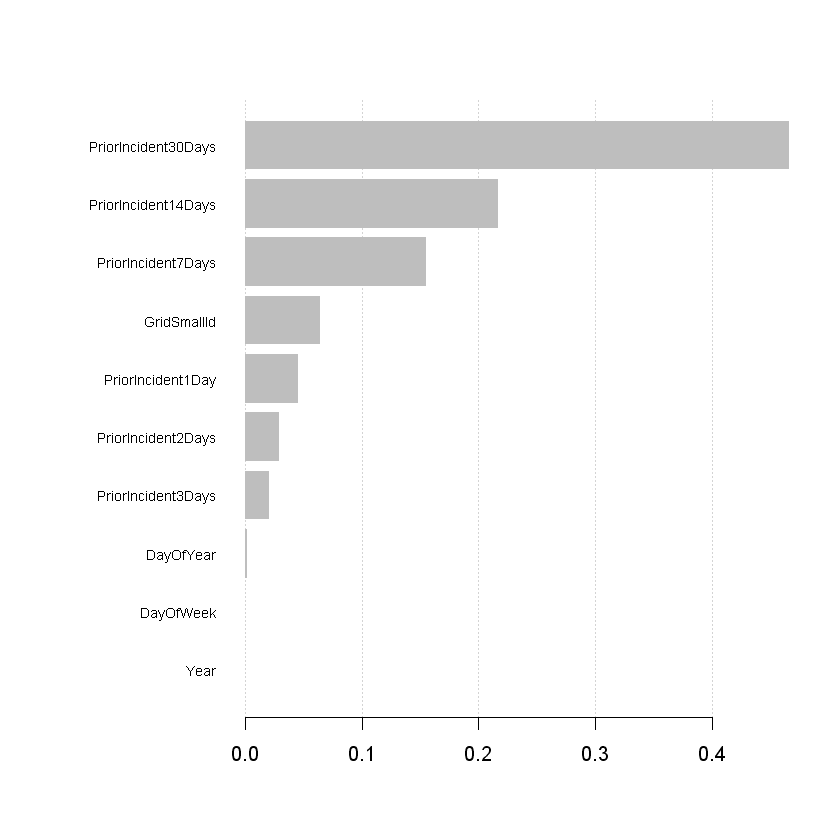

In [8]:
# Compute feature importance matrix
importance_matrix <- xgb.importance(feature.names, model = clf)

# Graph important features
xgb.plot.importance(importance_matrix[1:10,])

### Predict on Test and Check ROC Curve
The last step is to check our predictions against the test data set and see how well they did. We always hope that the ROC curve will spike up really high and really quick, but that is not always the case. In our example, we have a decent score with only basic features included in the model. This definitely shows us that we can do the predictions and more time should be invested to make it better.

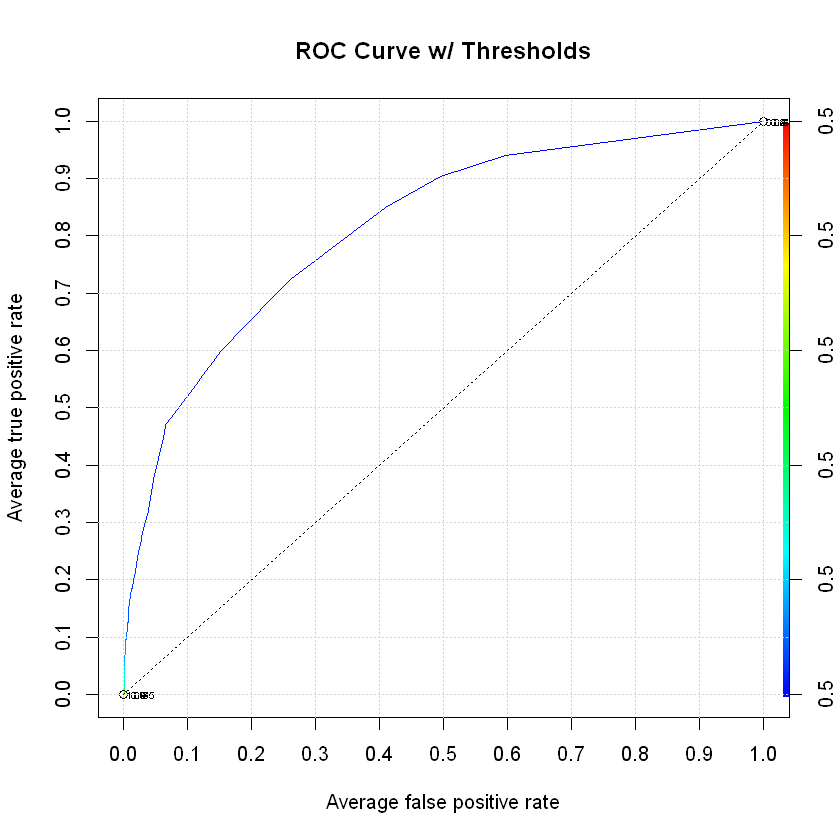

In [14]:
# Predict on test data
preds <- predict(clf, dtest)

# Graph AUC curve
xgb.pred <- prediction(preds, test$target)
xgb.perf <- performance(xgb.pred, "tpr", "fpr")

plot(xgb.perf,
     avg="threshold",
     colorize=TRUE,
     lwd=1,
     main="ROC Curve w/ Thresholds",
     print.cutoffs.at=seq(0, 1, by=0.05),
     text.adj=c(-0.5, 0.5),
     text.cex=0.5)
grid(col="lightgray")
axis(1, at=seq(0, 1, by=0.1))
axis(2, at=seq(0, 1, by=0.1))
abline(v=c(0.1, 0.3, 0.5, 0.7, 0.9), col="lightgray", lty="dotted")
abline(h=c(0.1, 0.3, 0.5, 0.7, 0.9), col="lightgray", lty="dotted")
lines(x=c(0, 1), y=c(0, 1), col="black", lty="dotted")

### Prepare Data for Reporting
Next we can add in the longitude and latitude coordinates for the test data set and export it to a CSV file. This will allow us to take a look at the actual predictions on a map in a BI tool like Tableau.

In [17]:
# Read in the grid coordinates
gridsmall <- sqlQuery(dbhandle, 'select * from gridsmall')

# Merge the predictions with the test data
results <- cbind(test, preds)

# Merge the grid coordinates with the test data
results <- merge(results, gridsmall, by="GridSmallId")

head(results)

# Save to file
write.csv(results,"Data\\CrimePredictions.csv", row.names = TRUE)

GridSmallId,target,DayOfWeek,MonthOfYear,DayOfYear,Year,PriorIncident1Day,PriorIncident2Days,PriorIncident3Days,PriorIncident7Days,PriorIncident14Days,PriorIncident30Days,preds,BotLeftLatitude,TopRightLatitude,BotLeftLongitude,TopRightLongitude
1,0,4,2,53,2017,0,0,0,0,0,0,0.4960257,39.20041,39.20128,-76.71162,-76.7107
1,0,3,2,59,2017,0,0,0,0,0,0,0.4960257,39.20041,39.20128,-76.71162,-76.7107
1,0,5,2,54,2017,0,0,0,0,0,0,0.4960257,39.20041,39.20128,-76.71162,-76.7107
1,0,2,2,58,2017,0,0,0,0,0,0,0.4960257,39.20041,39.20128,-76.71162,-76.7107
1,0,7,2,56,2017,0,0,0,0,0,0,0.4960257,39.20041,39.20128,-76.71162,-76.7107
1,0,1,2,57,2017,0,0,0,0,0,0,0.4960257,39.20041,39.20128,-76.71162,-76.7107


### What Next?
This tutorial got us started with doing geographical time series predictions using crime data. We can see that the predictions are definitely working, but there is more work to be done with creating features. We might want to add in some other features that check a larger area for prior crime occurences. Another useful step would be to change our predictions to run hourly and map squad car patrol routes by time of day. Even if the predictions are not perfect, as long as you are putting a police officer in the general vicinity of a crime then they can respond much faster.